In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and Process Data

In [3]:
df_features_train = pd.read_csv("Data_D1/gin_gout_ratio.csv", header=None)
X_train = df_features_train.values

df_labels_train = pd.read_csv("Data_D1/test_info.csv", header=None)
V_train = df_labels_train.iloc[:, 0].values
C_train = df_labels_train.iloc[:, 1].values
A_train = V_train - C_train
y_train = np.column_stack((A_train, C_train))

# === Load D2 (Test) Features & Labels ===
df_features_test = pd.read_csv("Data_D2/gin_gout_ratio.csv", header=None)
X_test = df_features_test.values

df_labels_test = pd.read_csv("Data_D2/test_info.csv", header=None)
V_test = df_labels_test.iloc[:, 0].values
C_test = df_labels_test.iloc[:, 1].values
A_test = V_test - C_test
y_test = np.column_stack((A_test, C_test))

# Train Test Split and Transform

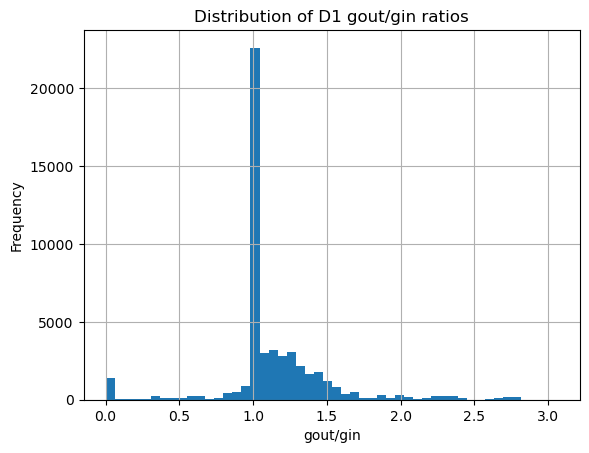

In [4]:
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

# === Visualize feature distribution ===
plt.hist(X_train.flatten(), bins=50)
plt.title("Distribution of D1 gout/gin ratios")
plt.xlabel("gout/gin")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [13]:
def build_bandwidth_estimator(k=25):
    model = keras.Sequential([
        layers.Input(shape=(k,)),
        layers.Dense(40, activation='relu'),
        layers.Dense(2, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [14]:
def build_iterative_bandwidth_estimator(k=20):
    model = keras.Sequential([
        layers.Input(shape=(k + 2,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(2, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [15]:
simple_model = build_bandwidth_estimator(X_train.shape[1])
simple_model.fit(X_train, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)
test_loss, test_mae = simple_model.evaluate(X_test, y_test_scaled)
print(f"Simple NN - Test Loss: {test_loss:.4f}, MAE: {test_mae:.4f}")

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6674 - mae: 0.6188 - val_loss: 0.3384 - val_mae: 0.5528
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1511 - mae: 0.3200 - val_loss: 0.3337 - val_mae: 0.5504
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1316 - mae: 0.2980 - val_loss: 0.2693 - val_mae: 0.4933
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1277 - mae: 0.2992 - val_loss: 0.2579 - val_mae: 0.4841
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1215 - mae: 0.2923 - val_loss: 0.3420 - val_mae: 0.5669
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1098 - mae: 0.2813 - val_loss: 0.2850 - val_mae: 0.5122
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1033 - mae: 0.2739 - val_loss: 0.2552 - val_mae: 0.4879
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1040 - mae: 0.2719 - val_loss: 0.2644 - val_mae: 0.4999
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1005 - mae: 

In [16]:
predictions_simple_scaled = simple_model.predict(X_test)
predictions_simple = scaler.inverse_transform(predictions_simple_scaled)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


In [17]:
iterative_model = build_iterative_bandwidth_estimator(X_train.shape[1])
iterative_model.fit(
    np.hstack([X_train, np.zeros((X_train.shape[0], 2))]), 
    y_train_scaled, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2
)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5394 - mae: 0.5368 - val_loss: 0.3327 - val_mae: 0.5701
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1289 - mae: 0.3073 - val_loss: 0.3355 - val_mae: 0.5707
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1177 - mae: 0.2945 - val_loss: 0.2772 - val_mae: 0.5157
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1126 - mae: 0.2877 - val_loss: 0.2700 - val_mae: 0.5108
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1026 - mae: 0.2745 - val_loss: 0.2441 - val_mae: 0.4736
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0937 - mae: 0.2588 - val_loss: 0.2108 - val_mae: 0.4373
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0833 - mae: 0.2450 - val_loss: 0.1680 - val_mae: 0.3902
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0810 - mae: 0.2415 - val_loss: 0.1802 - val_mae: 0.3983
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0667 - mae: 

In [18]:
def iterative_prediction(model, X, num_iterations=5, initial_A=50, initial_C=100):
    A_pred = np.full((X.shape[0], 1), initial_A)
    C_pred = np.full((X.shape[0], 1), initial_C)
    for _ in range(num_iterations):
        input_data = np.hstack([X, A_pred, C_pred])
        pred_scaled = model.predict(input_data, verbose=0)
        A_pred, C_pred = pred_scaled[:, 0:1], pred_scaled[:, 1:2]
    return A_pred, C_pred


In [19]:
A_pred_scaled, C_pred_scaled = iterative_prediction(iterative_model, X_test)
iterative_preds = scaler.inverse_transform(np.hstack([A_pred_scaled, C_pred_scaled]))

In [20]:
y_test_actual = y_test
A_true = y_test_actual[:, 0]
C_true = y_test_actual[:, 1]

A_simple = predictions_simple[:, 0]
C_simple = predictions_simple[:, 1]

A_iterative = iterative_preds[:, 0]
C_iterative = iterative_preds[:, 1]

In [21]:
df_C_comparison = pd.DataFrame({
    "True C (Cross Traffic)": C_true,
    "Predicted C (Simple NN)": C_simple,
    "Predicted C (Iterative NN)": C_iterative
})
print(df_C_comparison.head(20))
print("\nUnique Cross Traffic values in this batch:", np.unique(C_true))


    True C (Cross Traffic)  Predicted C (Simple NN)  \
0                     12.5               380.612152   
1                     12.5                43.523373   
2                     12.5                34.623444   
3                     12.5                23.821888   
4                     12.5                25.871944   
5                     12.5                38.869797   
6                     12.5                36.895203   
7                     12.5                25.377686   
8                     12.5                30.927664   
9                     12.5                28.304863   
10                    12.5                35.579544   
11                    12.5                32.598656   
12                    12.5                34.391193   
13                    12.5                35.651630   
14                    12.5                34.964539   
15                    12.5                25.930250   
16                    12.5                33.169106   
17        

In [30]:
def plot_grouped_C_predictions(true_C, pred_C_dict):
    unique_C = np.sort(np.unique(true_C))
    bin_width = 0.1  # very narrow bin just to filter

    plt.figure(figsize=(8, 5.5))

    styles = {
        "Simple NN": {"color": "tab:blue", "marker": "o"},
        "Iterative NN": {"color": "tab:orange", "marker": "s"}
    }

    for label, pred_C in pred_C_dict.items():
        means, stds = [], []
        for val in unique_C:
            mask = np.abs(true_C - val) < bin_width
            if np.any(mask):
                means.append(np.mean(pred_C[mask]))
                stds.append(np.std(pred_C[mask]))
            else:
                means.append(np.nan)
                stds.append(np.nan)

        plt.errorbar(
            unique_C, means, yerr=stds, fmt=styles[label]["marker"] + "-", 
            capsize=5, label=label, color=styles[label]["color"],
            markersize=8, linewidth=2
        )

    # Ideal y = x line (only over the unique x range)
    min_val = 0
    max_val = max(unique_C) + 10
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal (y = x)', linewidth=1.5)

    # Plot formatting
    plt.xlabel("True Cross Traffic (C) [Mbps]", fontsize=12)
    plt.ylabel("Predicted Cross Traffic [Mbps]", fontsize=12)
    plt.title("Grouped Cross Traffic Predictions with Error Bars (D1 → D2)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(unique_C)
    plt.xlim(0, max(unique_C) + 10)
    plt.ylim(0, max([np.nanmax(p) for p in pred_C_dict.values()]) + 15)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()


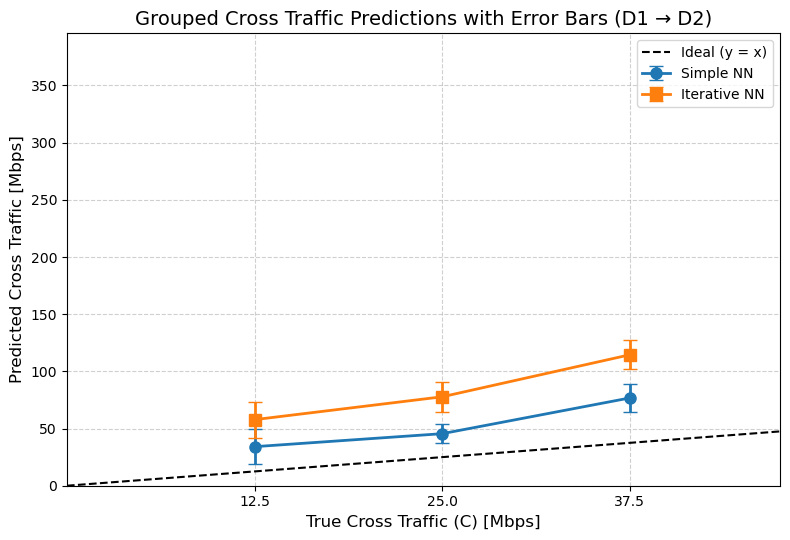

In [32]:
plot_grouped_C_predictions(
    C_true,
    {
        "Simple NN": C_simple,
        "Iterative NN": C_iterative
    }
)